# Импорт библиотек и чтение датасетов

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка данных
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

Подготовка данных

In [237]:
# Загрузка данных
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

# Подготовка данных
train_df['dt'] = pd.to_datetime(train_df['dt'], dayfirst=True)
test_df['dt'] = pd.to_datetime(test_df['dt'], dayfirst=True)
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')

# Объединение данных
combined_df = pd.concat([train_df[['dt', 'Price']], test_df[['dt', 'Price']]]).reset_index(drop=True)
X = combined_df.drop(columns=['Price']).iloc[:-1, :]
y = combined_df['Price'].values[1:]
X['Price_source'] = combined_df['Price'].values[:-1]
y = y[1:]
X = X.iloc[1:, :].reset_index(drop=True)

Разделение данных на обучающие и тестовые. Обучение модели. Метрики

In [238]:
# Разделение данных
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Логарифмирование целевой переменной
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)
model_cv = CatBoostRegressor(iterations=2000, learning_rate=0.04, depth=1, loss_function='MAE', verbose=0)
mae_scores = cross_val_score(model_cv, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model_cv, X_train, y_train_log, cv=tscv, scoring='r2')

# Обучение модели
model = CatBoostRegressor(iterations=2000, learning_rate=0.03, depth=1, loss_function='MAE', early_stopping_rounds=100, verbose=0)
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

# Предсказание
preds = np.expm1(model.predict(X_test))

# Метрики
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.6649
MAE: 5856.1810
RMSE: 6626.4751
Средний MAE на кросс-валидации: 0.0565
Средний R² на кросс-валидации: 0.7362


Проверка работы модели на графике

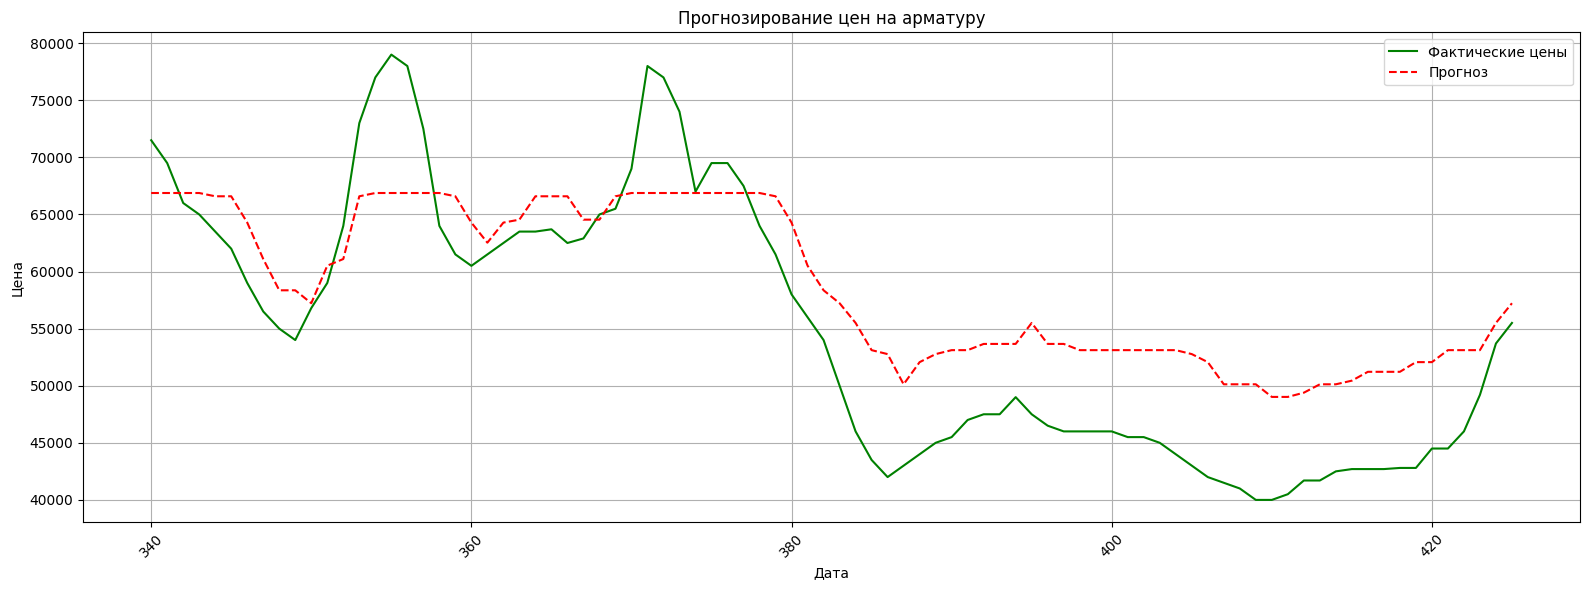

In [239]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сохранение модели
model.save_model("catboost_model.cbm")

#### Визуализация данных для обучения